# Different agents for the multi-armed bandit problem

This notebook contains different learning agents for the multi-armed bandit problem: A random agent, a greedy agent, an epsilon-greedy agent, and an upper confidence bound agent

In [1]:
import gym
import gym_bandits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Ten-armed bandit: A slot machine with 10 levers, each having a value q*(a): the mean reward obtained when pulling it.

In [2]:
env = gym.make("BanditTenArmedGaussian-v0")

WARN: Environment '<class 'gym_bandits.bandit.BanditTenArmedGaussian'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


In [3]:
print("States",env.observation_space)
print("Actions",env.action_space)

States Discrete(1)
Actions Discrete(10)


In [4]:
class Agent:
    def __init__(self,n_bandits):
        self.n_bandits = n_bandits
        self.reset()
    def reset(self):
        self.all_n = np.zeros(self.n_bandits)
        self.all_Q = np.zeros(self.n_bandits)
    def update(self,state,action,reward,t):
        self.all_n[action]+=1
        self.all_Q[action]+=(reward-self.all_Q[action])/self.all_n[action]

In [49]:
def run_multi_armed_bandit(env,n_runs,time_steps,agent):
    runs = []
    for n in range(n_runs):
        rewards = []
        observation = env.reset()
        agent.reset()
        for t in range(time_steps):
            action = agent.next_action(observation)
            observation, reward, done, info = env.step(action)
            agent.update(observation,action,reward,t)
            rewards.append(reward)
        runs.append(rewards)
    runs = np.array(runs)
    return runs.mean(axis=0)

In [42]:
def run_experiment(agent,n_runs=2000): 
    runs = []
    for n in range(n_runs):
        run = []
        observation = env.reset()
        agent.reset()
        for i_episode in range(1000):
            action = agent.next_action(observation)
            observation, reward, done, info = env.step(action)
            agent.update(observation,action,reward)
            run.append(reward)
        runs.append(run)
    a = np.array(runs)
    return a.mean(axis=0)

RANDOM AGENT

Every action is completely random

In [6]:
class RandomAgent(Agent):
    def next_action(self,observation):
        return np.random.randint(0,self.n_bandits)

In [7]:
random_agent = RandomAgent(n_bandits=10)

GREEDY AGENT

Always chooses the action with the highest estimated value. Only exploitation, no exploration

In [8]:
class GreedyAgent(Agent):
    def next_action(self,observation):
        return self.all_Q.argmax()

In [9]:
greedy_agent = GreedyAgent(10)

EPSILON-GREEDY AGENT

Most of the time chooses the action with the highest estimated value. With a probability of epsilon, it tries a random action

In [10]:
class EpsilonGreedyAgent(Agent):
    def __init__(self,n_bandits,epsilon):
        self.n_bandits = n_bandits
        self.epsilon = epsilon
        self.reset()
    def next_action(self,observation):
        if np.random.random()<self.epsilon:
            return np.random.randint(self.n_bandits)
        else:
            return self.all_Q.argmax()

In [45]:
class EpsilonGreedyAgent:
    def __init__(self,n_bandits,epsilon):
        self.n_bandits = n_bandits
        self.epsilon = epsilon
    def reset(self):
        self.all_n = np.zeros(self.n_bandits)
        self.all_Q = np.zeros(self.n_bandits)
    def update(self,state,action,reward):
        self.all_n[action]+=1
        self.all_Q[action]+=(reward-self.all_Q[action])/self.all_n[action]
    def next_action(self,observation):
        p = np.random.random()
        if p<self.epsilon:
            return np.random.randint(0,self.n_bandits)
        else:
            return self.all_Q.argmax()

In [46]:
epsilon_greedy_agent = EpsilonGreedyAgent(10,0.1)

UPPER CONFIDENCE BOUND AGENT

In [12]:
class UCB_LearningAgent:
    def __init__(self, n_bandits):
        self.n_bandits = n_bandits
        self.reset()
    def reset(self):
        self.Q_all = np.random.rand(self.n_bandits)
        self.N_all = np.ones(self.n_bandits) # intialize number of selections for all bandits as ones
        self.ucb_all = np.array([self.Q_all[i] + np.sqrt(2*(np.log(1)/self.N_all[i])) for i in range(self.n_bandits)])
    def update(self, observation,action, reward, t):
        self.N_all[action]+=1 # increment number of selections for selected bandit (action)
        self.Q_all[action]+=(reward - self.Q_all[action])/self.N_all[action] # update Q with the formula. Average so far
        self.ucb_all = np.array([self.Q_all[i] + np.sqrt(2*(np.log(t)/self.N_all[i])) for i in range(10)])
    def next_action(self,observation):
        return self.ucb_all.argmax()

In [13]:
ucb_agent = UCB_LearningAgent(10)

TESTING

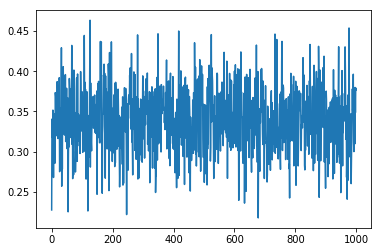

In [50]:
random = run_multi_armed_bandit(env,1000,1000,random_agent)
plt.plot(random)
plt.show()

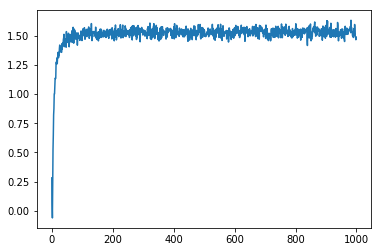

In [53]:
greedy = run_multi_armed_bandit(env,1000,1000,greedy_agent)
plt.plot(greedy)
plt.show()

(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)
(1000, 1000)


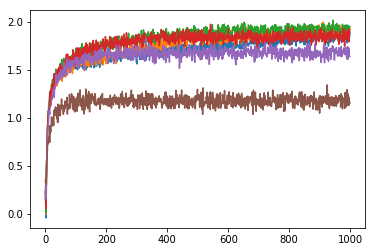

In [48]:
for epsilon in [0.01,0.02,0.05,0.1,0.2,0.5]:
    epsilon_greedy_agent = EpsilonGreedyAgent(10,epsilon)
    epsilon_greedy = run_experiment(epsilon_greedy_agent,n_runs=1000)
    plt.plot(epsilon_greedy)
plt.show()

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


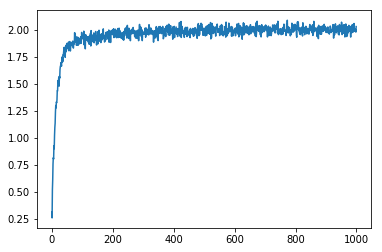

In [54]:
ucb = run_multi_armed_bandit(env,1000,1000,ucb_agent)
plt.plot(ucb)
plt.show()

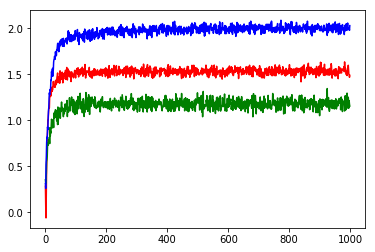

In [55]:
plt.plot(greedy,c="r")
plt.plot(epsilon_greedy,c="g")
plt.plot(ucb,c="b")
plt.show()